### Imports

In [288]:
# Data Processing Modules
import numpy as np
import pandas as pd
# Model Training Modules
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
# Model Testing Modules
from sklearn import metrics
# Visualization Modules
import matplotlib.pyplot as plt
import seaborn as sns

### Read in Data

In [289]:
df = pd.read_csv('Maths.csv')

In [290]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Prepare Target

<AxesSubplot:>

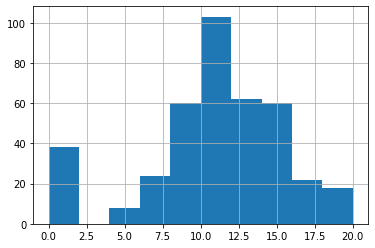

In [291]:
df['G3'].hist()

11.0


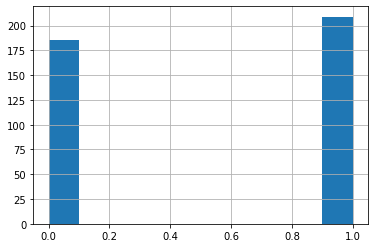

In [292]:
# Create a binary target variable. Is the total grade greater than or equal to the median or not. 
cutoff = df['G3'].median()
print(cutoff)
df['Target'] = (df['G3'] >= cutoff).astype(int)
df['Target'].hist()
df = df.drop(columns=['G1', 'G2', 'G3'])

### Encode Features

In [293]:
# Convert categorical variables to numerical
for feature in df.columns:
    if df[feature].dtype.kind not in 'iufc':
        # Column is not numerical
        df[feature] = df[feature].astype("category")
        df[feature] = df[feature].cat.codes.astype("int")

In [294]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Target
0,0,0,18,1,0,0,4,4,0,4,...,0,0,4,3,4,1,1,3,6,0
1,0,0,17,1,0,1,1,1,0,2,...,1,0,5,3,3,1,1,3,4,0
2,0,0,15,1,1,1,1,1,0,2,...,1,0,4,3,2,2,3,3,10,0
3,0,0,15,1,0,1,4,2,1,3,...,1,1,3,2,2,1,1,5,2,1
4,0,0,16,1,0,1,3,3,2,2,...,0,0,4,3,2,1,2,5,4,0


### Feature Selection

In [295]:
X = df.drop(columns=['Target'])
y = df['Target']

In [296]:
select = SelectKBest(k=15)
X_new = select.fit_transform(X, y)
filt = select.get_support()
features = X.columns

In [297]:
# Print out the top 10 most important features
important_features = features[filt]
print(important_features)

Index(['school', 'sex', 'age', 'address', 'Medu', 'Fedu', 'Mjob', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'higher', 'internet', 'goout',
       'Walc'],
      dtype='object')


In [298]:
# Filter data to most important features
X_selected_features = X[important_features]

### Check Statistical Properties of Data

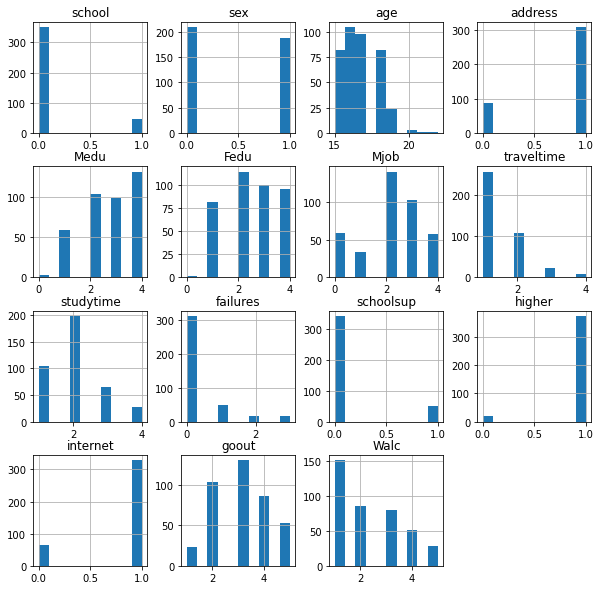

In [299]:
# Plot distributions for each variable used
X_selected_features.hist(figsize=(10,10))
plt.show()

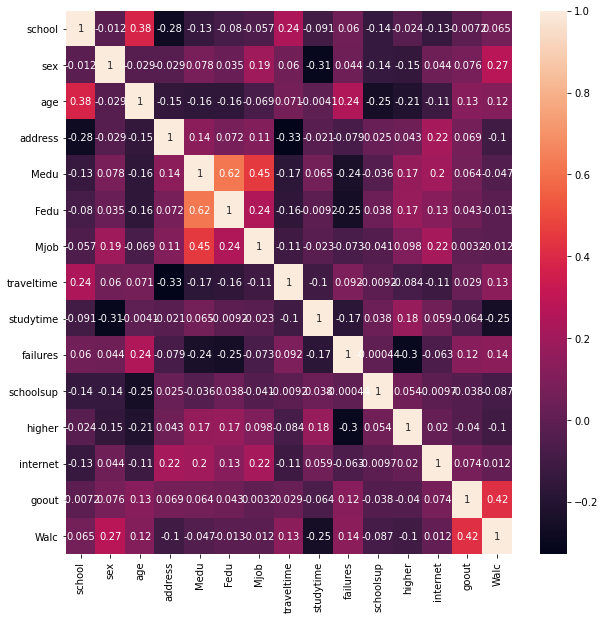

In [317]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(X_selected_features.corr(), annot=True)
plt.show()

### Split Data into Training and Testing Sets

In [301]:
# Split data into training and testing sets with a 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size=0.25, random_state=5)

In [302]:
print(f"There are {y_test.sum()} students in the test set that are above average")
print(f"There are {len(y_test) - y_test.sum()} students in the test set that are below average")

There are 49 students in the test set that are above average
There are 50 students in the test set that are below average


### Logistic Regression Classifier

In [303]:
# Train our logistic regression model
logreg = LogisticRegression(random_state=0)

# Train with cross validation
parameters = [{'penalty':['none','l2'], 
               'C':[1, 10, 100, 1000]}]
lr_model = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           verbose=0)


lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("The best parameters across ALL searched params:\n",lr_model.best_params_)

C:\Users\Amit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Amit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Amit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Amit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Amit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Amit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the

ACCURACY OF THE MODEL:  0.6565656565656566
The best parameters across ALL searched params:
 {'C': 1, 'penalty': 'l2'}


C:\Users\Amit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [304]:
# Evaluate the logistic regression model using a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[26, 24],
       [10, 39]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

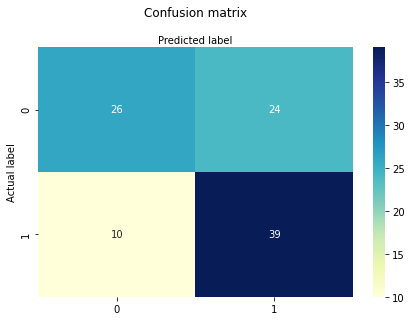

In [305]:
# Visualize Confusion Matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Random Forest Classifier

In [306]:
# Training with cross validation
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [307]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [3, None],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [50, 66, 83, 100, 116, 133, 150, 166,
                                          183, 200]},
             verbose=2)

In [308]:
rf_model = rf_random.best_estimator_
y_pred = rf_model.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("The best parameters across ALL searched params:\n",rf_random.best_params_)

ACCURACY OF THE MODEL:  0.6363636363636364
The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}


In [309]:
# Evaluate the RF classifier model using a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[21, 29],
       [ 7, 42]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

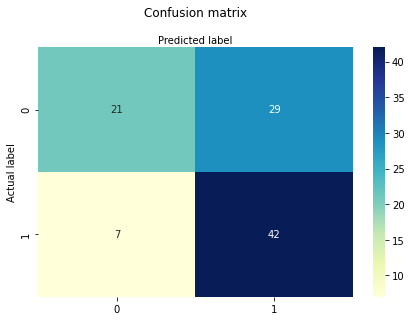

In [310]:
# Visualize Confusion Matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### KNN Classifier

In [311]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [312]:
y_pred = knn_gscv.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("The best parameters across ALL searched params:\n",knn_gscv.best_params_)

ACCURACY OF THE MODEL:  0.6363636363636364
The best parameters across ALL searched params:
 {'n_neighbors': 5}


In [313]:
# Evaluate the RF classifier model using a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[26, 24],
       [12, 37]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

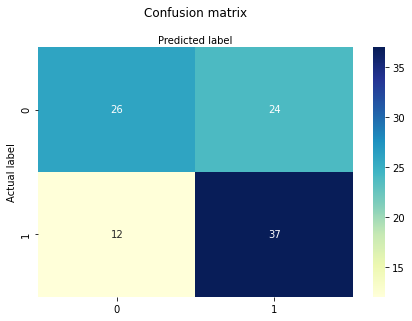

In [314]:
# Visualize Confusion Matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [315]:
# TODO:
# - Select best performing model
# - visualize and show feature importance
# - interpret results